# 📘 PROJECT: IT SALARY PREDICTION
## FILE 2: ADVANCED FEATURE ENGINEERING (V4 - SUPER CLEAN)

**Cập nhật V4:**
- Xử lý triệt để các trường hợp nhiễu (Mechanical, Driver...).
- Tối ưu hóa NLP: Loại bỏ stopword địa phương (ha, noi, hcm).
- **Feature mới:** `Level_Score` - Gán trọng số cứng cho các từ khóa cấp bậc để giảm thiểu việc dự đoán nhầm Junior/Senior thành Middle.

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import re
import pickle

# Thư viện NLP & ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import hstack, csr_matrix

import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


---
## 1. LOAD DATA & CLEAN NOISE (Lọc rác thô)
Bước này loại bỏ ngay những job không liên quan đến IT phần mềm để tránh làm nhiễu mô hình.

In [ ]:
# Kết nối Database
conn = sqlite3.connect("career_data.db")
df = pd.read_sql("SELECT * FROM clean_jobs", conn)
conn.close()

print(f"📊 Dữ liệu gốc: {df.shape}")

# 1. Danh sách từ khóa KHÔNG PHẢI IT (Blacklist)
blacklist = [
    'mechanical', 'co khi', 'driver', 'lai xe', 'giao hang', 'shipper',
    'kios', 'bao ve', 'tap vu', 'kitchen', 'bep', 'phuc vu', 'sale admin',
    'telesale', 'thoi vu', 'cong nhan', 'may mac', 'det may'
]

# Hàm lọc rác
def is_spam(title):
    t = str(title).lower()
    for word in blacklist:
        if word in t:
            return True
    return False

# Áp dụng lọc
df = df[~df['job_title'].apply(is_spam)]
print(f"✅ Dữ liệu sau khi lọc rác: {df.shape} (Đã loại bỏ các job không liên quan)")

📊 Dữ liệu gốc: (1045, 5)
✅ Dữ liệu sau khi lọc rác: (1040, 5) (Đã loại bỏ các job không liên quan)


---
## 2. TEXT NORMALIZATION (Chuẩn hóa văn bản nâng cao)
Xử lý các lỗi dính chữ số (ví dụ: `ho25` -> `ho`) và bỏ dấu tiếng Việt.

In [ ]:
def normalize_text(text):
    text = str(text).lower()
    # Bỏ dấu tiếng Việt
    text = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', text)
    text = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', text)
    text = re.sub(r'[oòóọỏõôồốộổỗơờớợởỡ]', 'o', text)
    text = re.sub(r'[uùúụủũưừứựửữ]', 'u', text)
    text = re.sub(r'[iìíịỉĩ]', 'i', text)
    text = re.sub(r'[yỳýỵỷỹ]', 'y', text)
    text = re.sub(r'[đ]', 'd', text)

    # QUAN TRỌNG: Tách số ra khỏi chữ hoặc xóa số không cần thiết
    # Ví dụ: "Java8" -> "Java", "ho25" -> "ho"
    text = re.sub(r'\d+', '', text)

    # Chỉ giữ lại chữ cái và khoảng trắng
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Xóa khoảng trắng thừa
    return " ".join(text.split())

df['title_clean'] = df['job_title'].apply(normalize_text)
df['company_clean'] = df['company'].apply(normalize_text)

print("Mẫu kết quả chuẩn hóa:")
display(df[['job_title', 'title_clean']].head(3))

Mẫu kết quả chuẩn hóa:


,job_title,title_clean
0,Trưởng nhóm Lập trình Java (tham gia các cuộc ...,truong nhom lap trinh java tham gia cac cuoc t...
1,Network Engineer - Kỹ Sư Mạng (Không Yêu Cầu K...,network engineer ky su mang khong yeu cau kinh...
2,Quality Assurance Manager (Test Automation Man...,quality assurance manager test automation manager


---
## 3. FEATURE ENGINEERING: LEVEL & RANK (Quan trọng)
Để sửa lỗi Junior/Senior bị đoán thành Middle, ta cần một Feature chấm điểm cấp bậc cụ thể.

In [ ]:
# 1. Trích xuất số năm kinh nghiệm (Giữ nguyên logic cũ vì tốt)
def extract_experience(text):
    # Tìm số năm kinh nghiệm trong Title gốc (chưa xóa số)
    match = re.search(r'(\d+)\s*(?:-|to)?\s*(\d+)?\s*(?:nam|year|yoe|kinh nghiem|exp)', str(text).lower())
    if match:
        num1 = float(match.group(1))
        if match.group(2):
            return (num1 + float(match.group(2))) / 2
        return num1
    return -1 # Đánh dấu là không tìm thấy để xử lý sau

df['exp_years'] = df['job_title'].apply(extract_experience)

# 2. Feature Mới: Job Level Score (Quy đổi Text sang Số thứ tự)
# Intern=0, Fresher=1, Junior=2, Middle=3, Senior=4, Manager=5
def get_level_score(text):
    t = text.lower()
    if any(k in t for k in ['thuc tap', 'intern', 'part time', 'parttime']): return 0
    if any(k in t for k in ['fresher', 'moi tot nghiep', 'junior', 'so cap']): return 1
    if any(k in t for k in ['senior', 'chuyen gia', 'cao cap', 'lead', 'principal']): return 4
    if any(k in t for k in ['manager', 'truong phong', 'giam doc', 'head', 'ceo', 'cto']): return 5
    return 2 # Mặc định là Middle/Chuyên viên

df['level_score'] = df['title_clean'].apply(get_level_score)

# Xử lý điền khuyết cho exp_years dựa trên level_score
# Logic: Nếu không tìm thấy năm, gán theo Level
level_to_exp = {0: 0.5, 1: 1.0, 2: 2.5, 4: 5.0, 5: 8.0}
df['exp_years'] = df.apply(lambda row: level_to_exp[row['level_score']] if row['exp_years'] == -1 else row['exp_years'], axis=1)
df['exp_years'] = df['exp_years'].clip(upper=15)

print("Phân bố Level Score (0: Intern -> 5: Manager):")
print(df['level_score'].value_counts().sort_index())

Phân bố Level Score (0: Intern -> 5: Manager):
level_score
0     29
1     13
2    748
4    182
5     68
Name: count, dtype: int64


---
## 4. FEATURE: COMPANY & TECH

In [ ]:
# Check Company lớn
def is_big_tech(company_name):
    c = str(company_name).lower()
    keywords = ['bank', 'ngan hang', 'group', 'tap doan', 'holdings', 'global', 'fpt', 'viettel', 'vin', 'samsung']
    return 1 if any(k in c for k in keywords) else 0

# Check Title tiếng Anh
def is_english_title(text):
    vn_keywords = ['tuyen', 'nhan vien', 'chuyen vien', 'ky su', 'thuc tap', 'truong', 'phong']
    return 0 if any(w in text for w in vn_keywords) else 1

df['is_big_company'] = df['company_clean'].apply(is_big_tech)
df['is_english'] = df['title_clean'].apply(is_english_title)

---
## 5. NLP: TF-IDF & CATEGORY (Tối ưu hóa)
Loại bỏ các từ địa phương (`ha`, `noi`) để tránh Overfitting vào địa điểm (vì đã có cột Location riêng).

In [ ]:
# 1. Categorize (Giữ nguyên)
def categorize_job(title_clean):
    t = " " + title_clean + " "
    if any(k in t for k in [' manager ', ' lead ', ' pm ', ' po ', ' head ']): return 'Management'
    if any(k in t for k in [' data ', ' ai ', ' machine ', ' analyst ']): return 'Data/AI'
    if any(k in t for k in [' cloud ', ' devops ', ' sysadmin ', ' network ']): return 'Cloud/System'
    if any(k in t for k in [' tester ', ' qa ', ' qc ', ' ba ']): return 'QA/BA'
    if any(k in t for k in [' mobile ', ' android ', ' ios ']): return 'Mobile'
    if any(k in t for k in [' java ', ' .net ', ' web ', ' dev ', ' frontend ', ' backend ', ' fullstack ']): return 'Dev'
    return 'Support/Other'

df['job_category'] = df['title_clean'].apply(categorize_job)

# 2. TF-IDF Optimization
# Stopwords mở rộng: Xóa tên địa điểm và các từ chung chung không mang ý nghĩa kỹ thuật
my_stop_words = [
    'tuyen', 'gap', 'hcm', 'ha', 'noi', 'ho', 'chi', 'minh', 'da', 'nang',
    'nhan', 'vien', 'staff', 'member', 'cong', 'ty', 'tnhh', 'cp', 'co', 'phan',
    'job', 'work', 'cv', 'recruit', 'tuyen', 'dung'
]

print("⏳ Đang chạy TF-IDF...")
tfidf = TfidfVectorizer(
    ngram_range=(1, 2), # Lấy cả cụm 2 từ (VD: "data analyst")
    min_df=3,
    max_features=2500,
    stop_words=my_stop_words
)

# Tạo Label tạm để dùng Chi-Square Selection
df['salary_label'], bin_edges = pd.cut(df['salary_million_vnd'], bins=[0, 15, 35, 999], labels=[0, 1, 2], retbins=True)

X_text_raw = tfidf.fit_transform(df['title_clean'])
selector = SelectKBest(chi2, k=600)
X_text_selected = selector.fit_transform(X_text_raw, df['salary_label'])

print(f"✅ Kích thước Text Features: {X_text_selected.shape}")

⏳ Đang chạy TF-IDF...
✅ Kích thước Text Features: (1040, 585)


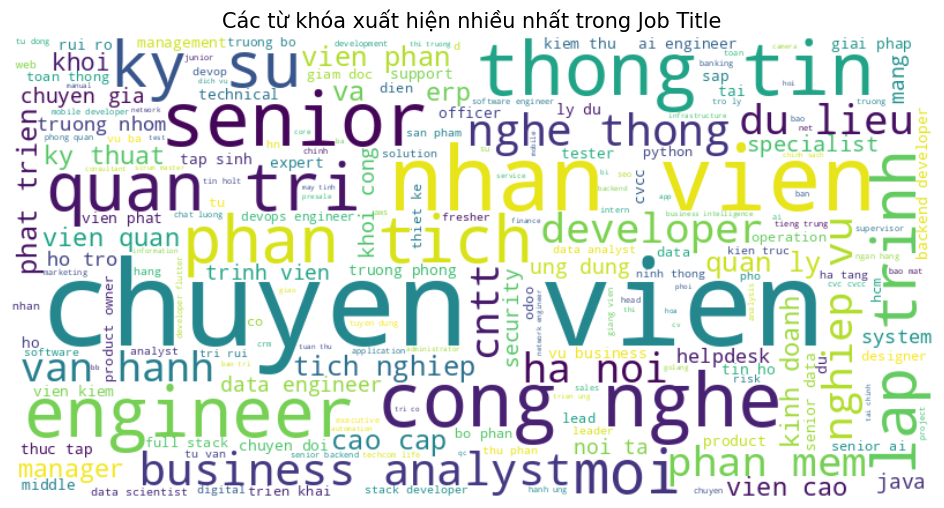

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Vẽ WordCloud
text_combined = " ".join(df['title_clean'])
wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Các từ khóa xuất hiện nhiều nhất trong Job Title', fontsize=15)
plt.show()

# TF-IDF
my_stop_words = [
    'tuyen', 'gap', 'hcm', 'ha', 'noi', 'ho', 'chi', 'minh', 'da', 'nang',
    'nhan', 'vien', 'staff', 'member', 'cong', 'ty', 'tnhh', 'cp', 'co', 'phan',
    'job', 'work', 'cv', 'recruit', 'tuyen', 'dung'
]
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_features=2500, stop_words=my_stop_words)

df['salary_label'], bin_edges = pd.cut(df['salary_million_vnd'], bins=[0, 15, 35, 999], labels=[0, 1, 2], retbins=True)

X_text_raw = tfidf.fit_transform(df['title_clean'])
selector = SelectKBest(chi2, k=600)
X_text_selected = selector.fit_transform(X_text_raw, df['salary_label'])

---
## 6. COMBINE & SAVE (Đóng gói dữ liệu)
Ghép tất cả Feature lại: Text + OneHot + Numeric

In [67]:
## 6. COMBINE & SAVE (PHIÊN BẢN PRO - LƯU CẢ TRANSFORMERS)
# Lưu ý: Cần lưu cả các bộ biến đổi (Scaler, Vectorizer) để qua File 3 dùng lại y hệt.

# 1. One-Hot Encoding
ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_cat_encoded = ohe.fit_transform(df[['job_category', 'location']])

# 2. Numeric Features Scaling
scaler = MinMaxScaler()
num_cols = ['exp_years', 'level_score', 'is_big_company', 'is_english']
X_num = df[num_cols].values
X_num_scaled = csr_matrix(scaler.fit_transform(X_num))

# 3. Ghép tất cả
X_final = hstack([X_text_selected, X_cat_encoded, X_num_scaled])

# 4. Đóng gói dữ liệu + Bộ công cụ (Transformers)
data_package = {
    'X': X_final,
    'y': df['salary_label'],
    'raw_df': df,
    # LƯU QUAN TRỌNG: Các bộ xử lý để tái sử dụng
    'transformers': {
        'tfidf': tfidf,       # Để xử lý text nhập vào y hệt lúc train
        'selector': selector, # Để lọc đúng 600 từ khóa tốt nhất
        'ohe': ohe,           # Để mã hóa Location/Category
        'scaler': scaler      # Để chuẩn hóa số năm kinh nghiệm
    },
    'feature_names': (
        [tfidf.get_feature_names_out()[i] for i in selector.get_support(indices=True)] +
        list(ohe.get_feature_names_out()) +
        num_cols
    )
}

with open('processed_data_v3.pkl', 'wb') as f:
    pickle.dump(data_package, f)

print("💾 Đã lưu 'processed_data_v3.pkl' kèm theo bộ Transformers.")
print("👉 Bây giờ bạn hãy qua File 3 để chạy Inference chuẩn xác 100%!")

💾 Đã lưu 'processed_data_v3.pkl' kèm theo bộ Transformers.
👉 Bây giờ bạn hãy qua File 3 để chạy Inference chuẩn xác 100%!
